In [1]:
import numpy as np
import matplotlib.pyplot as plt
from src.plotsiii import plotiii1, plotiii2
from src.plotsv import plotv1, plotv2

### Tensorflow HMC 

In [2]:
from corner import corner
import tensorflow as tf
import tensorflow_probability as tfp

tdf = tfp.distributions

In [3]:
# set seed
np.random.seed(120420)
tf.random.set_seed(120420)

# read text file
file_path = 'src/lighthouse_flash_data.txt'

# Read the data
def read_data(file_path):
    '''
    Function to read data from a text file and return it as two lists.
    '''
    # initialise lists to store the data
    column1 = []  
    column2 = []  
    
    with open(file_path, 'r') as file:  # Open the file for reading
        for line in file:  # Iterate over each line in the file
            parts = line.split()  # Split the line by whitespace
            
            # Append the parts to their respective column lists
            column1.append(float(parts[0]))
            column2.append(float(parts[1]))

    return column1, column2


In [4]:
# observed flashes
x_observed = np.array(read_data(file_path)[0], dtype=np.float32)

# Constants for the uniform prior
a, b = -3, 2  # Bounds for alpha
c, d = 0.5, 5  # Bounds for beta

# Joint log probability function
def joint_log_prob(x, alpha, beta):
    # Likelihood for a Cauchy distribution
    likelihood = tdf.Cauchy(loc=alpha, scale=beta).log_prob(x)
    log_likelihood = tf.reduce_sum(likelihood)

    # Prior for alpha
    log_prior_alpha = tf.where(
        tf.logical_and(alpha > a, alpha < b),
        tf.math.log(1.0 / (b - a)),
        -np.inf
    )

    # Prior for beta
    log_prior_beta = tf.where(
        tf.logical_and(beta > c, beta < d),
        tf.math.log(1.0 / (d - c)),
        -np.inf
    )

    return log_prior_alpha + log_prior_beta + log_likelihood

# Define the unnormalized posterior (target distribution)
def unnormalized_posterior(alpha, beta):
    return joint_log_prob(x_observed, alpha, beta)


In [7]:
# nuts kernel
nuts_kernel = tfp.mcmc.NoUTurnSampler(
    target_log_prob_fn=unnormalized_posterior,
    step_size=np.float64(.5) #0.08
)

num_burnin_steps = 800 #100
# Adpative step size
num_adaptation_steps = int(num_burnin_steps * 0.9)
adaptive_nuts = tfp.mcmc.SimpleStepSizeAdaptation(
  nuts_kernel,
  num_adaptation_steps=int(num_adaptation_steps),
  target_accept_prob=np.float64(0.65))  # 0.75


# run hmc
@tf.function
def run_chain(initial_state, num_results=10000, num_burnin_steps=num_burnin_steps): # 30000, 300
  samples, kernel_results = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      kernel=adaptive_nuts,
      trace_fn=lambda current_state, kernel_results: kernel_results)
  return samples, kernel_results

# Number of chains and initial values
num_chains = 4

initial_alpha = tf.random.uniform([num_chains, 1], minval=a, maxval=b)  # Shape [num_chains, 1]
initial_beta = tf.random.uniform([num_chains, 1], minval=c, maxval=d)  # Shape [num_chains, 1]

# Combine initial states
initial_state = [initial_alpha, initial_beta]

# Run the chains
samples, kernel_results = run_chain(initial_state=initial_state)
alpha_samples, beta_samples = samples


In [8]:
import tensorflow as tf

# Assuming alpha_samples and beta_samples are defined and have the shape (50000, 8, 1)
combined_samples = tf.concat([alpha_samples, beta_samples], axis=-1)
combined_samples

from zeus import AutoCorrTime

taus = AutoCorrTime(np.array(combined_samples))
print('Autocorrelation:', taus)

tau = max(taus)
print(f"{tau = }")


Autocorrelation: [12.95552826 58.2420578 ]
tau = 58.24205780029297


In [9]:
ess = tfp.mcmc.effective_sample_size(combined_samples)

# `ess` will be a Tensor of the same shape as a single sample (the '...' part),
# containing the ESS for each parameter (or dimension of the sample space).

# To evaluate and print the ESS values, you might need to convert them to numpy arrays
# if you're not using eager execution in TensorFlow
ess_numpy = ess.numpy()
print("Effective Sample Size:\n", ess_numpy)

aggregated_ess = tf.reduce_sum(ess, axis=0)

# `aggregated_ess` will now be a 1D tensor with the aggregated ESS for each parameter
print("Aggregated Effective Sample Size for each parameter:\n", aggregated_ess.numpy())

Effective Sample Size:
 [[1270.4375   372.82242]
 [1062.7745   393.84857]
 [ 506.03976   88.18845]
 [ 724.66345  407.5681 ]]
Aggregated Effective Sample Size for each parameter:
 [3563.915  1262.4276]


In [10]:
# Assuming alpha_samples and beta_samples are your MCMC outputs
# First, remove the unnecessary middle dimension (which is 1 in your case)
alpha_flat = alpha_samples.numpy().squeeze()  # This changes shape from (300, 1, 1) to (300,)
beta_flat = beta_samples.numpy().squeeze()  # Same here

# Stack alpha and beta samples along a new axis to get the correct shape
samples_np = np.stack([alpha_flat, beta_flat], axis=-1)  # This should give you a shape of (300, 2)

# mean and std of alpha and beta
mean_alpha = np.mean(alpha_samples)
std_alpha = np.std(alpha_samples)

mean_beta = np.mean(beta_samples)
std_beta = np.std(beta_samples)

print('alpha:', mean_alpha, std_alpha)
print('beta:', mean_beta, std_beta)

alpha: -0.4583626 0.46231943
beta: 1.8285398 0.52346057


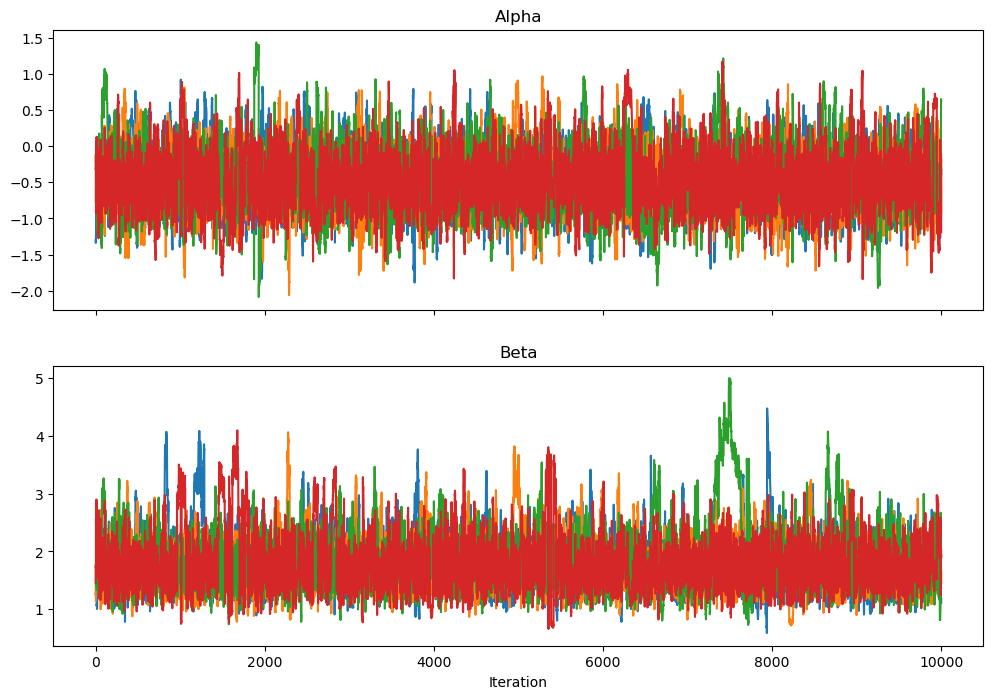

In [11]:
# plot alpha and beta samples
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 8))
axes[0].plot(alpha_flat)
axes[0].title.set_text('Alpha')
axes[1].plot(beta_flat)
axes[1].title.set_text('Beta')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('')


plt.show()


/Users/maxtalberg/miniconda3/envs/S2-env/lib/python3.8/site-packages/arviz/data/base.py:169: UserWarning: More chains (10000) than draws (4). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


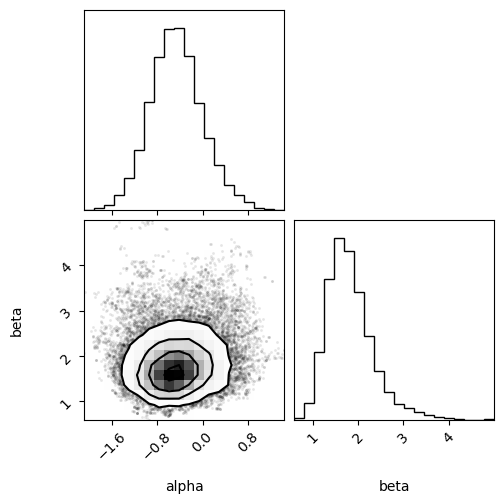

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import corner


# Now, use the corner plot
corner.corner(samples_np, labels=['alpha', 'beta'])
plt.show()


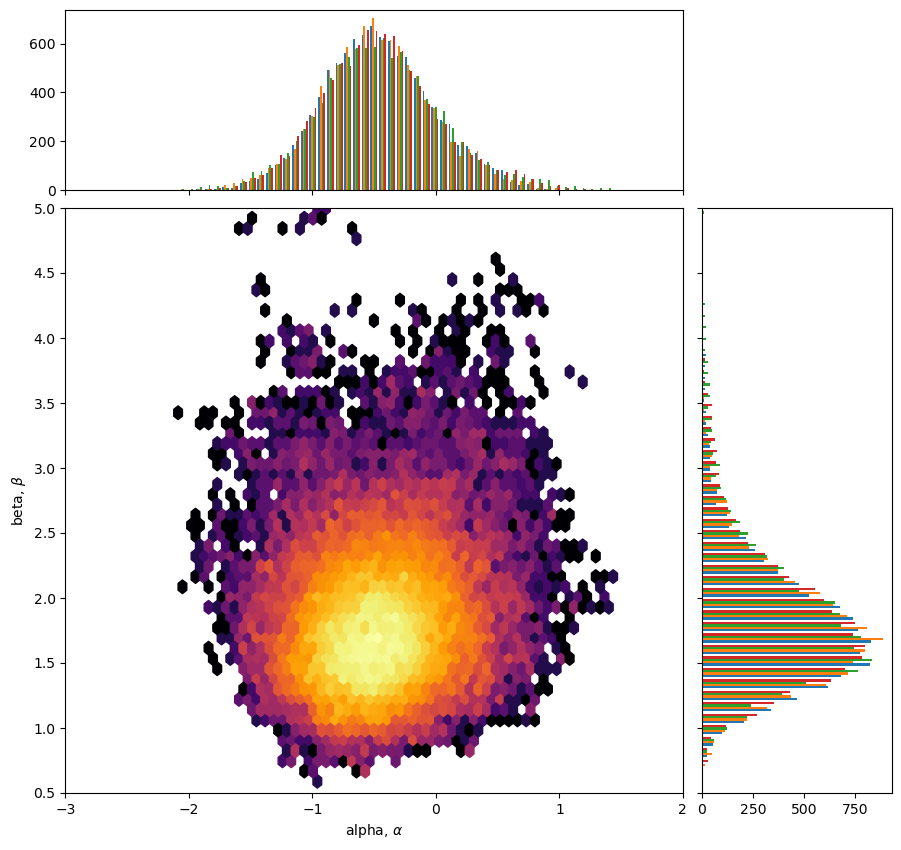

In [13]:
samples_flat = alpha_flat, beta_flat
xrange = a, b
yrange = c, d
plotv1(samples_flat, xrange, yrange)

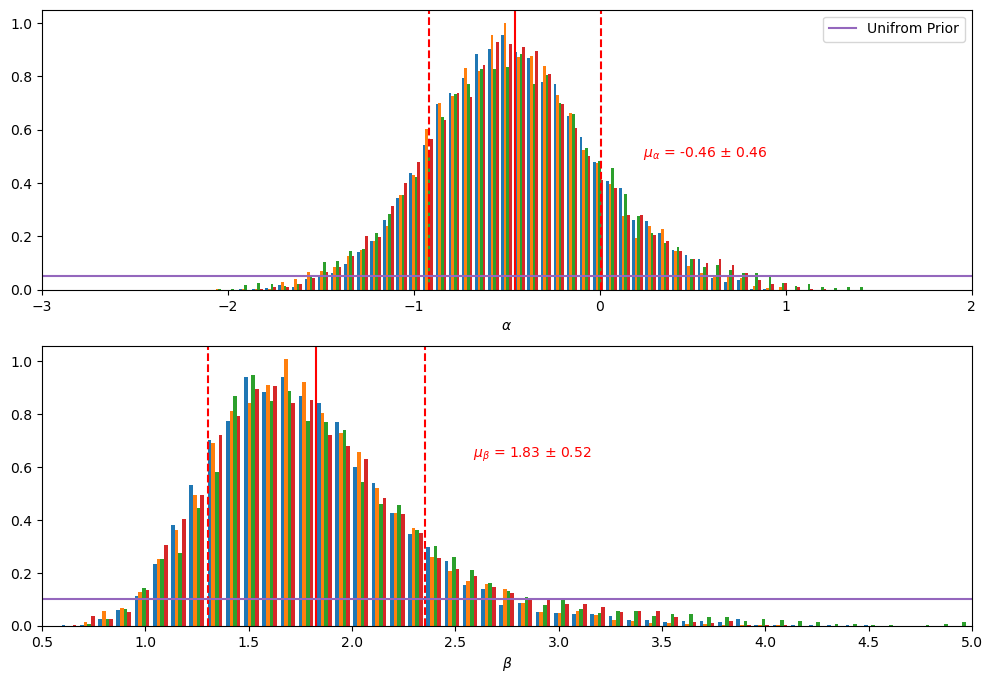

In [14]:
plotv2(samples_flat, xrange, yrange)

In [16]:
hmc_kernel_results = kernel_results.inner_results


r_hat = tfp.mcmc.potential_scale_reduction(samples)
print("Acceptance rate:", hmc_kernel_results.is_accepted.numpy().mean())
r_hat_numpy = [tensor.numpy() for tensor in r_hat]

# Now you can print the r_hat values
print("R-hat diagnostic (per latent variable):", r_hat_numpy)


Acceptance rate: 0.953275
R-hat diagnostic (per latent variable): [array([1.000835], dtype=float32), array([1.0073869], dtype=float32)]


## Intensity and Flash Locations

In [60]:
# observed Intensities
I_observed = np.array(read_data(file_path)[1], dtype=np.float32)
# observed Flashes
x_observed = np.array(read_data(file_path)[0], dtype=np.float32)

# constants for the uniform prior
a = tf.cast(-1, tf.float32) # -3
b = tf.cast(2, tf.float32) # 2
c = tf.cast(0.5, tf.float32)
d = tf.cast(2, tf.float32)

# constants for the uniform prior
e = tf.cast(0.5, tf.float32)
f = tf.cast(6, tf.float32)  


# joint log probability function for flash locations
def joint_log_prob_x(x, alpha, beta):
    # likelihood
    likelihood = tdf.Cauchy(loc=alpha, scale=beta).log_prob(x)
    log_likelihood = tf.reduce_sum(likelihood)

    # prior
    log_prior_alpha = tf.where(
        tf.logical_and(alpha > a, alpha < b),
        tf.math.log(1/(b-a)),
        -np.inf
    
    )
    log_prior_beta = tf.where(
        tf.logical_and(beta > c, beta < d),
        tf.math.log(1/(d-c)),
        -np.inf
    )

    return log_prior_alpha + log_prior_beta + log_likelihood

# joint log probability function for flash locations
def joint_log_prob_I(x, I, alpha, beta, I0):

    # likelihood
    d = tf.sqrt(beta**2 + (x - alpha)**2)
    mu = tf.math.log(I0) - 2*tf.math.log(d)
    likelihood = tdf.LogNormal(loc = mu, scale = 1).log_prob(I)
    log_likelihood = tf.reduce_sum(likelihood)

    # prior
    log_uniform_prior = tf.where(
        tf.logical_and(I0 >e, I0 < f),
        -tf.math.log(I0) - tf.math.log(tf.math.log(f) - tf.math.log(e)),
        -np.inf
    
    )

    return log_uniform_prior + log_likelihood


# Define the unnormalized posterior (target distribution)
def unnormalized_posterior(alpha, beta, I0):
    log_prob_x = joint_log_prob_x(x_observed, alpha, beta)
    log_prob_I = joint_log_prob_I(x_observed, I_observed, alpha, beta, I0)
    return log_prob_x + log_prob_I

In [82]:
# nuts kernel
nuts_kernel = tfp.mcmc.NoUTurnSampler(
    target_log_prob_fn=unnormalized_posterior,
    step_size=np.float64(0.5) #0.08
)

num_burnin_steps = 1000 #100
# Adpative step size
num_adaptation_steps = int(num_burnin_steps * 0.9)
adaptive_nuts = tfp.mcmc.SimpleStepSizeAdaptation(
  nuts_kernel,
  num_adaptation_steps=int(num_adaptation_steps),
  target_accept_prob=np.float64(0.65))  # 0.75


# run hmc
@tf.function
def run_chain(initial_state, num_results=10000, num_burnin_steps=num_burnin_steps): # 30000, 300
  samples, kernel_results = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      kernel=adaptive_nuts,
      trace_fn=lambda current_state, kernel_results: kernel_results)
  return samples, kernel_results

# Number of chains and initial values
num_chains = 8

initial_alpha = tf.random.uniform([num_chains, 1], minval=a, maxval=b)  # Shape [num_chains, 1]
initial_beta = tf.random.uniform([num_chains, 1], minval=c, maxval=d)  # Shape [num_chains, 1]
initial_I0 = tf.random.uniform([num_chains, 1], minval=e, maxval=f)  # Shape [num_chains, 1]

# Combine initial states
initial_state = [initial_alpha, initial_beta, initial_I0]

# Run the chains
samples, kernel_results = run_chain(initial_state=initial_state)
alpha_samples, beta_samples, I0_samples = samples

In [73]:
# Assuming alpha_samples and beta_samples are your MCMC outputs
# First, remove the unnecessary middle dimension (which is 1 in your case)
alpha_flat = alpha_samples.numpy().squeeze()  # This changes shape from (300, 1, 1) to (300,)
beta_flat = beta_samples.numpy().squeeze()  # Same here
I0_flat = I0_samples.numpy().squeeze()  # Same here

# Stack alpha and beta samples along a new axis to get the correct shape
samples_np = np.stack([alpha_flat, beta_flat, I0_flat], axis=-1)  # This should give you a shape of (300, 2)

# mean and std of alpha and beta and I0
mean_alpha = np.mean(alpha_samples)
std_alpha = np.std(alpha_samples)

mean_beta = np.mean(beta_samples)
std_beta = np.std(beta_samples)

mean_I0 = np.mean(I0_samples)
std_I0 = np.std(I0_samples)

print('alpha:', mean_alpha, std_alpha)
print('beta:', mean_beta, std_beta)
print('I0:', mean_I0, std_I0)

alpha: -0.20269206 0.21859515
beta: 1.3834208 0.21363623
I0: 3.3027606 0.613557


In [74]:
hmc_kernel_results = kernel_results.inner_results


r_hat = tfp.mcmc.potential_scale_reduction(samples)
print("Acceptance rate:", hmc_kernel_results.is_accepted.numpy().mean())
r_hat_numpy = [tensor.numpy() for tensor in r_hat]

# Now you can print the r_hat values
print("R-hat diagnostic (per latent variable):", r_hat_numpy)

Acceptance rate: 1.0
R-hat diagnostic (per latent variable): [array([1.0563098], dtype=float32), array([1.2216506], dtype=float32), array([1.5843278], dtype=float32)]


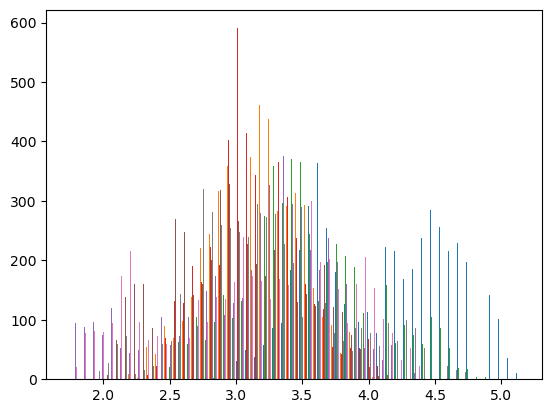

In [75]:
#histogram of I0
plt.hist(I0_flat, bins=100)
plt.show()

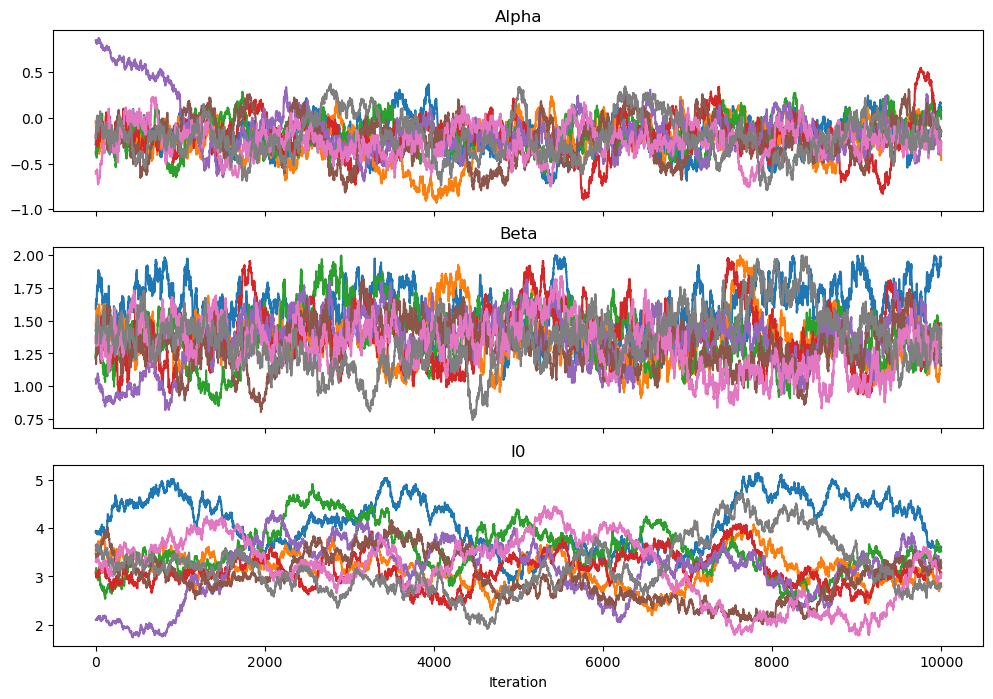

In [76]:
# plot alpha and beta samples
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(12, 8))
axes[0].plot(alpha_flat)
axes[0].title.set_text('Alpha')
axes[1].plot(beta_flat)
axes[1].title.set_text('Beta')
axes[1].set_ylabel('')
axes[2].plot(I0_flat)
axes[2].title.set_text('I0')
axes[2].set_xlabel('Iteration')


plt.show()


/Users/maxtalberg/miniconda3/envs/S2-env/lib/python3.8/site-packages/arviz/data/base.py:169: UserWarning: More chains (10000) than draws (8). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


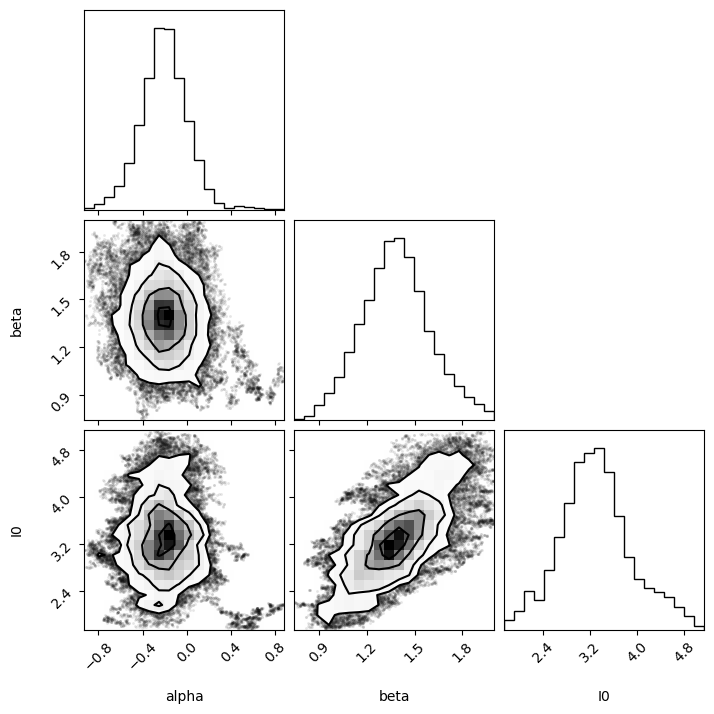

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import corner


# Now, use the corner plot
corner.corner(samples_np, labels=['alpha', 'beta', 'I0'])
plt.show()


In [78]:
r_hat = tfp.mcmc.potential_scale_reduction(samples)
r_hat

[<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.0563098], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.2216506], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.5843278], dtype=float32)>]

In [79]:
# Assuming alpha_samples and beta_samples are defined and have the shape (50000, 8, 1)
combined_samples = tf.concat([alpha_samples, beta_samples, I0_samples], axis=-1)
combined_samples

from zeus import AutoCorrTime

taus = AutoCorrTime(np.array(combined_samples))
print('Autocorrelation:', taus)

tau = max(taus)
print(f"{tau = }")


Autocorrelation: [ 321.94464111 1468.91308594 2838.37133789]
tau = 2838.371337890625


In [80]:
samples_stacked = tf.stack([tf.squeeze(chain, axis=-1) for chain in samples], axis=0)

# Now samples_stacked should have the shape [num_chains, num_samples, num_parameters]

# Compute the autocorrelation across the num_samples dimension
auto_corr = tfp.stats.auto_correlation(samples_stacked, axis=1)

# Check the shape and values of auto_corr
print(auto_corr.shape)
print(auto_corr)

(3, 10000, 8)
tf.Tensor(
[[[ 1.00000000e+00  1.00000000e+00  1.00000000e+00 ...  1.00000000e+00
    1.00000000e+00  1.00000000e+00]
  [ 9.91655409e-01  9.94417667e-01  9.90984380e-01 ...  9.94935691e-01
    9.90098178e-01  9.95062411e-01]
  [ 9.83477771e-01  9.88947809e-01  9.82346714e-01 ...  9.89874184e-01
    9.80046272e-01  9.90253031e-01]
  ...
  [-7.07040608e-01 -8.60279381e-01 -1.34261036e+00 ...  5.10093495e-02
    1.39714456e+00 -3.91091593e-02]
  [-6.76801145e-01 -8.80488276e-01 -1.26345241e+00 ...  3.06667145e-02
    1.44999039e+00 -4.47801761e-02]
  [-5.10704815e-01 -9.27024901e-01 -1.13283050e+00 ... -3.81901809e-05
    1.56430018e+00 -8.44014362e-02]]

 [[ 1.00000000e+00  1.00000000e+00  1.00000000e+00 ...  1.00000000e+00
    1.00000000e+00  1.00000000e+00]
  [ 9.92723048e-01  9.92962003e-01  9.94083226e-01 ...  9.90638554e-01
    9.92714882e-01  9.94777441e-01]
  [ 9.85434413e-01  9.85861063e-01  9.88214970e-01 ...  9.81552362e-01
    9.85710204e-01  9.89596069e-01]
  ..

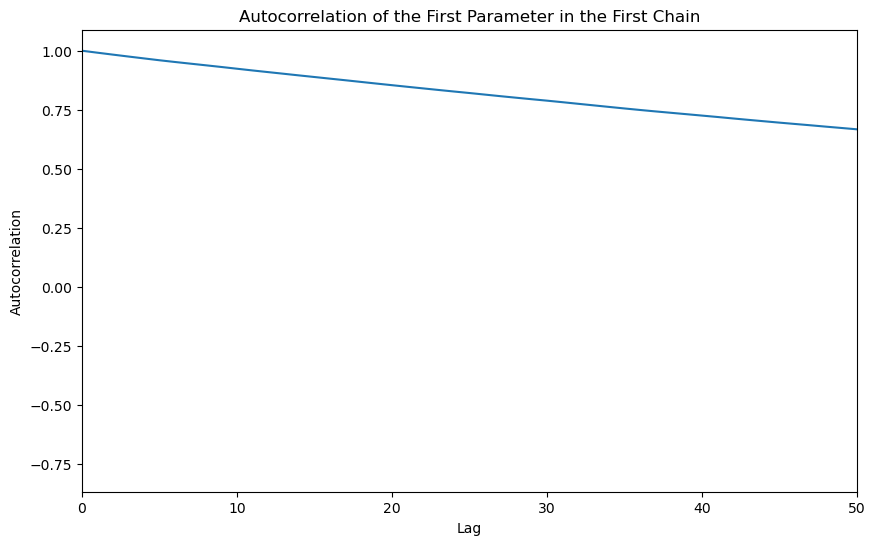

In [81]:
import matplotlib.pyplot as plt

# Select the autocorrelation data for the first parameter of the first chain
auto_corr_param1_chain1 = auto_corr[0, :, 0]  # Selecting the first chain and the first parameter

# Plot the autocorrelation
plt.figure(figsize=(10, 6))
plt.plot(auto_corr_param1_chain1)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of the First Parameter in the First Chain')
plt.xlim(0, 50)  # Limiting the x-axis to the first 50 lags for better visibility
plt.show()
